In [6]:
from Solar.src.Time_Series_First_Model import *
from Solar.src import Prep
from Solar.src.Time_Series_Stats_Step import *

# from src.Trend_Season_plots import *
# # visualization packages
import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# sns.set()
# import plotly.express as px
# plt.style.use('ggplot')
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [392]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV,  KFold
from sklearn.metrics import f1_score, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
%load_ext autoreload

In [8]:
%reload_ext autoreload

In [87]:
%autoreload

In [10]:
df = Prep.prep()

1 of 11 |    Reading in first dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
2 of 11 |    Reading in second dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
3 of 11 |    Concatenating datasets together
4 of 11 |    Cleaning up column names
5 of 11 |    Sorting values by installation_date
6 of 11 |    Assigning installation_date as index
7 of 11 |    Refining to only RES customer_segment
8 of 11 |    Replacing all null values with median values from same year
9 of 11 |    Adusting prices for inflation
10 of 11|    Creating target variable: cost_per_watt
11 of 11|    Removing > 1600 outliers above $25 per watt
Prep complete 
 ------------------------------------------------------------


In [11]:
sdf = df.loc[df.index.date > datetime.date(2001,12,31)]
syw = resamp_lag_ols(sdf)

In [398]:
s_lagg = create_lag(syw)

In [400]:
s_lagg

,y,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,,
2002-01-27,11.950,12.110,12.670,12.935
2002-02-03,11.820,11.950,12.110,12.670
2002-02-10,12.755,11.820,11.950,12.110
2002-02-17,10.860,12.755,11.820,11.950
2002-02-24,11.150,10.860,12.755,11.820
...,...,...,...,...
2018-12-09,3.790,3.780,3.780,3.790
2018-12-16,3.850,3.790,3.780,3.780


In [ ]:
888 * .8

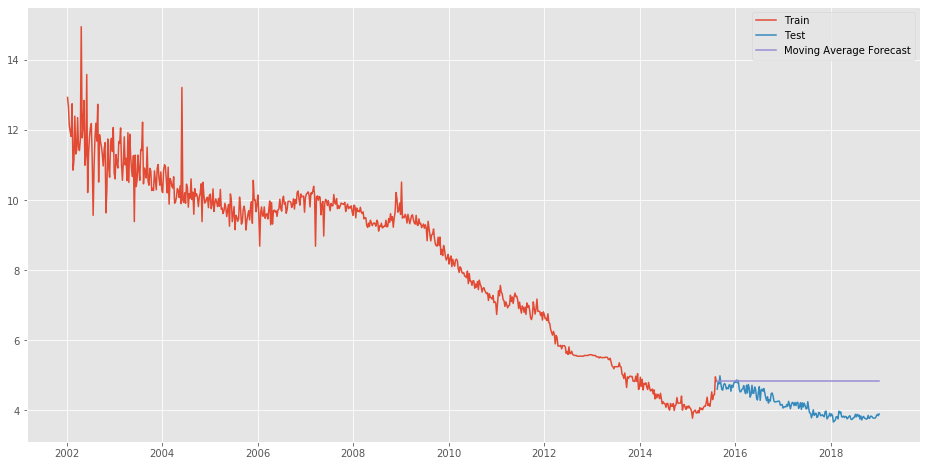

RMS =  0.7463725009084672


In [12]:
train = sl[:710]
test = syw[710:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).median().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
print('RMS = ' , rms)

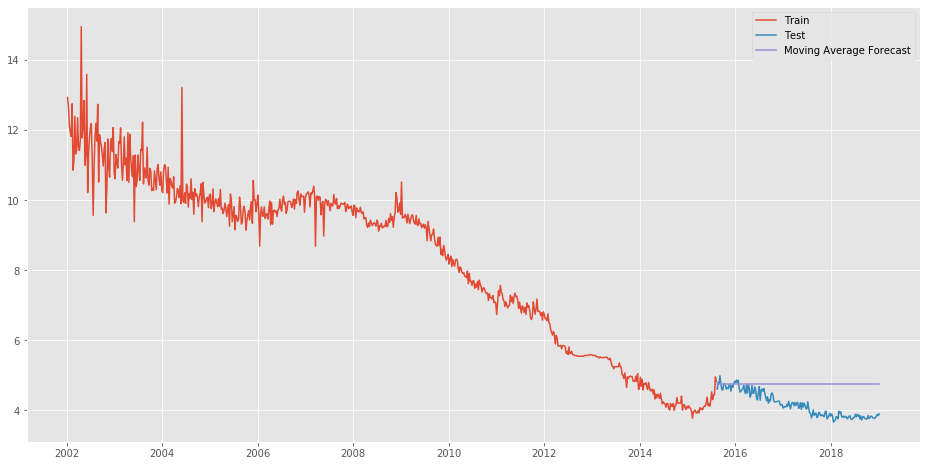

RMS =  0.6740504950763149


In [13]:
train = syw[:710]
test = syw[710:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
print('RMS = ' , rms)

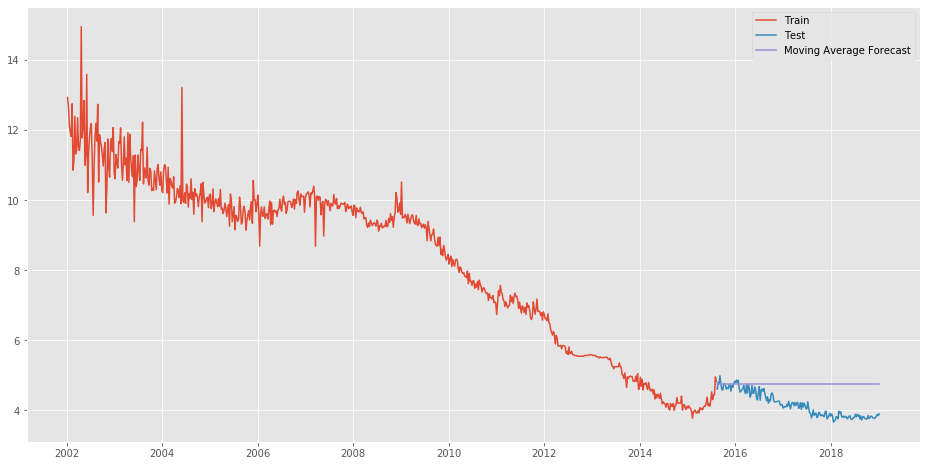

RMS =  0.6740504950763149


In [14]:
train = syw[:710]
test = syw[710:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
print('RMS = ' , rms)

In [15]:
yw = resamp_lag_ols(df)
lagg_cost = create_lag(yw)

ywn = pd.DataFrame(yw.cost_per_watt).dropna()

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from Solar.src.time_series_helpers import (to_col_vector,
                                 plot_acf_and_pacf,
                                 PolynomialBasisAndDummyizer)

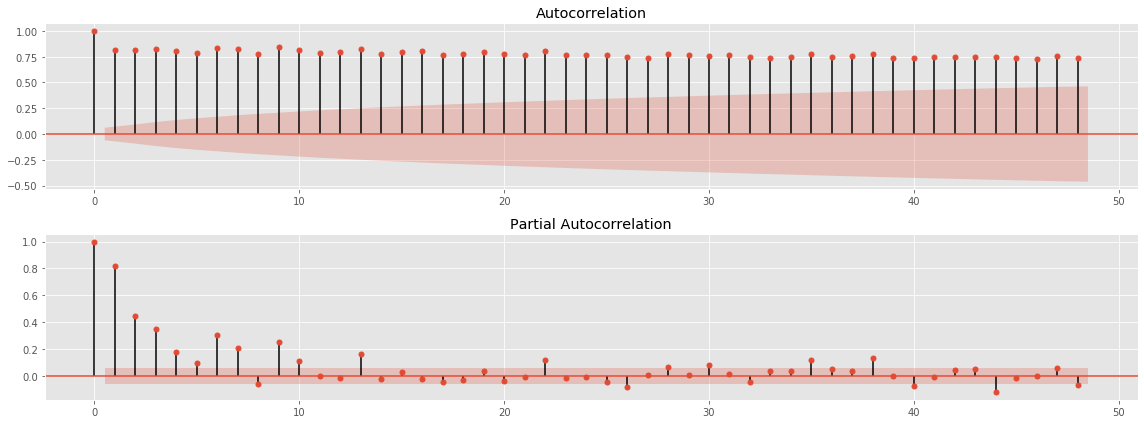

In [19]:
#Box Jenkins Method
fig, axs = plt.subplots(2, figsize=(16, 6))
plot_acf_and_pacf(ywn, axs)
plt.tight_layout()


ADF p-value: 0.00


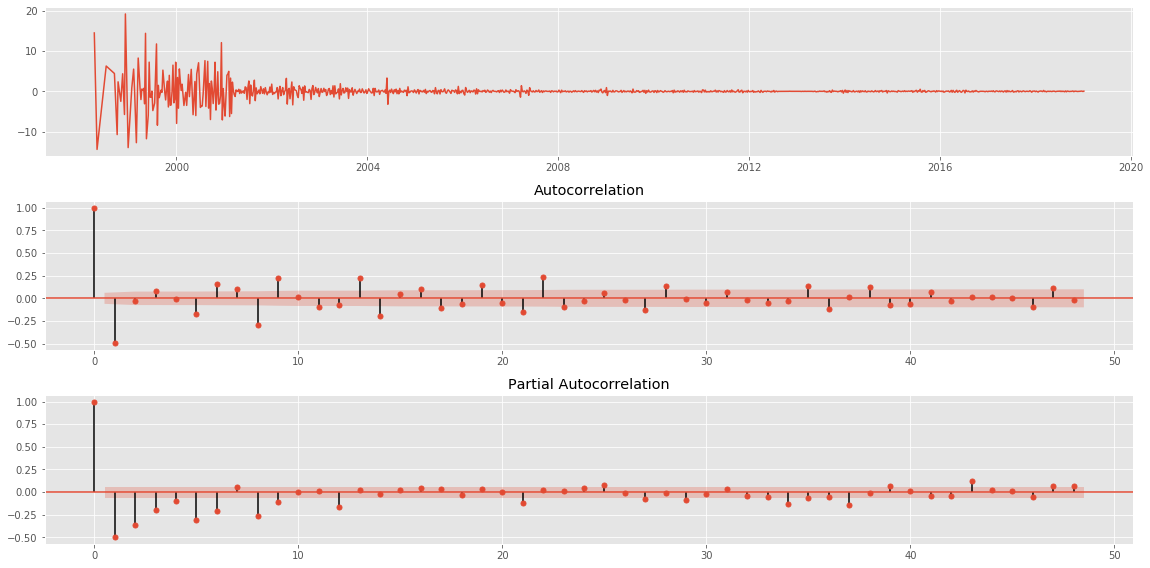

In [20]:
weekly_differences = ywn.diff(periods=1)

fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(weekly_differences.index, weekly_differences)
# The first entry in the differenced series is NaN.
plot_acf_and_pacf(weekly_differences[1:], axs[1:])
plt.tight_layout()
test = sm.tsa.stattools.adfuller(weekly_differences[1:])
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00


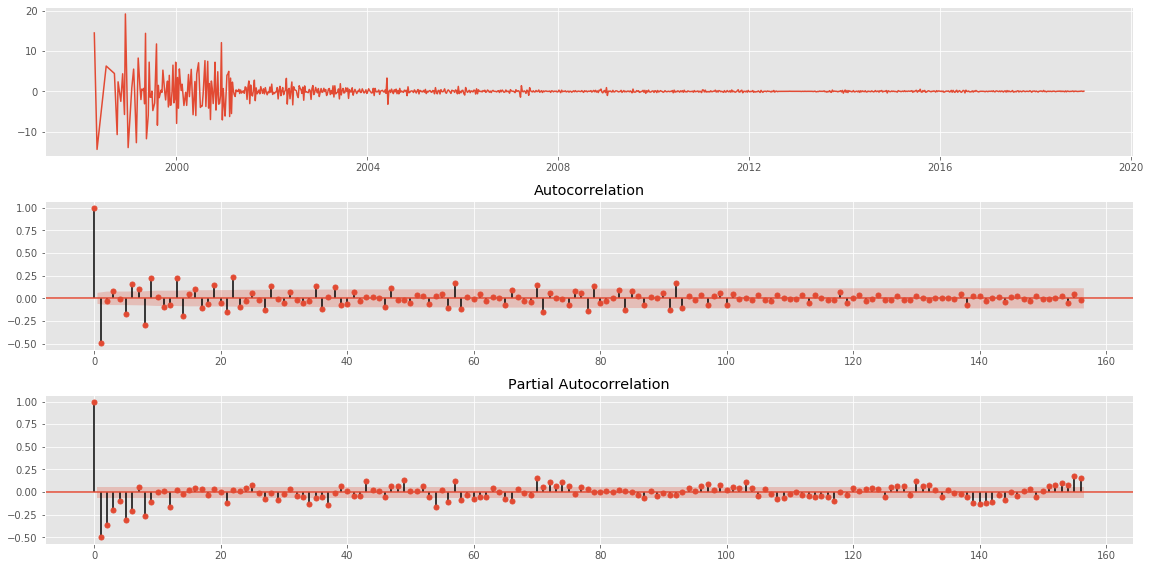

In [92]:
weekly_differences = ywn.diff(periods=1)

fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(weekly_differences.index, weekly_differences)
# The first entry in the differenced series is NaN.
plot_acf_and_pacf(weekly_differences[1:], axs[1:], lags=)
plt.tight_layout()
test = sm.tsa.stattools.adfuller(weekly_differences[1:])
print("ADF p-value: {0:2.2f}".format(test[1]))

In [ ]:
plot_acf_and_pacf()

In [91]:
52*3

156

In [96]:
syw

,cost_per_watt
installation_date,
2002-01-06,12.935
2002-01-13,12.670
2002-01-20,12.110
2002-01-27,11.950
2002-02-03,11.820
...,...
2018-12-09,3.790
2018-12-16,3.850
2018-12-23,3.890


In [22]:
X = add_constant(np.arange(1, len(ywn) + 1))
y = ywn

linear_trend = sm.OLS(y, X).fit().predict(X)

Text(0.5, 1.0, 'Weekly Median Cost Per Watt Over Time with Trendline')

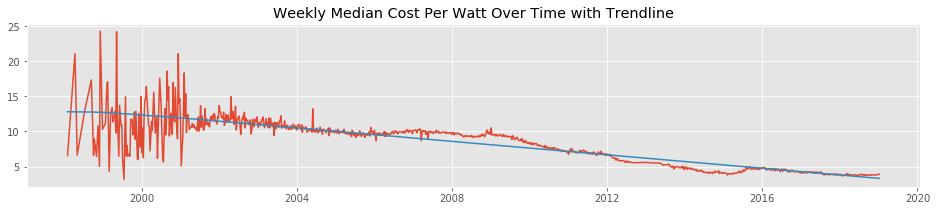

In [23]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(ywn.index, ywn)
ax.plot(ywn.index, linear_trend)
ax.set_title("Weekly Median Cost Per Watt Over Time with Trendline")

In [48]:
import statsmodels

In [49]:
import statsmodels.api as sm

In [51]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
linear_model = sm.OLS(y, X).fit()
linear_trend = linear_model.predict(X)

In [26]:
lm_residuals = pd.Series(ywn.cost_per_watt -linear_trend, index=ywn.index)

In [27]:
lm_residuals

installation_date
1998-02-01   -6.262260
1998-04-12    8.266917
1998-05-03   -6.173906
1998-07-12    0.125270
1998-09-13    4.569447
                ...   
2018-12-09    0.439066
2018-12-16    0.508243
2018-12-23    0.557420
2018-12-30    0.526597
2019-01-06    0.585774
Name: cost_per_watt, Length: 1036, dtype: float64

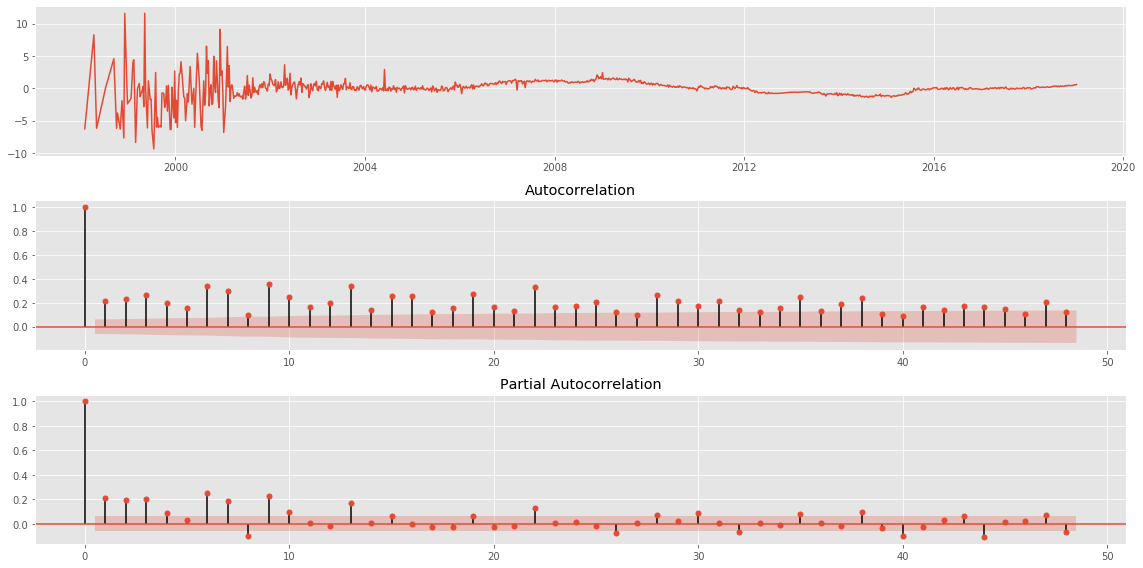

In [28]:
fig, axs = plt.subplots(3, figsize=(16, 8))
# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(lm_residuals.index, lm_residuals)
plot_acf_and_pacf(lm_residuals, axs[1:])
plt.tight_layout()

In [36]:
lm_residual_model = ARIMA(
    lm_residuals, order=( 1, 1, 1)).fit()

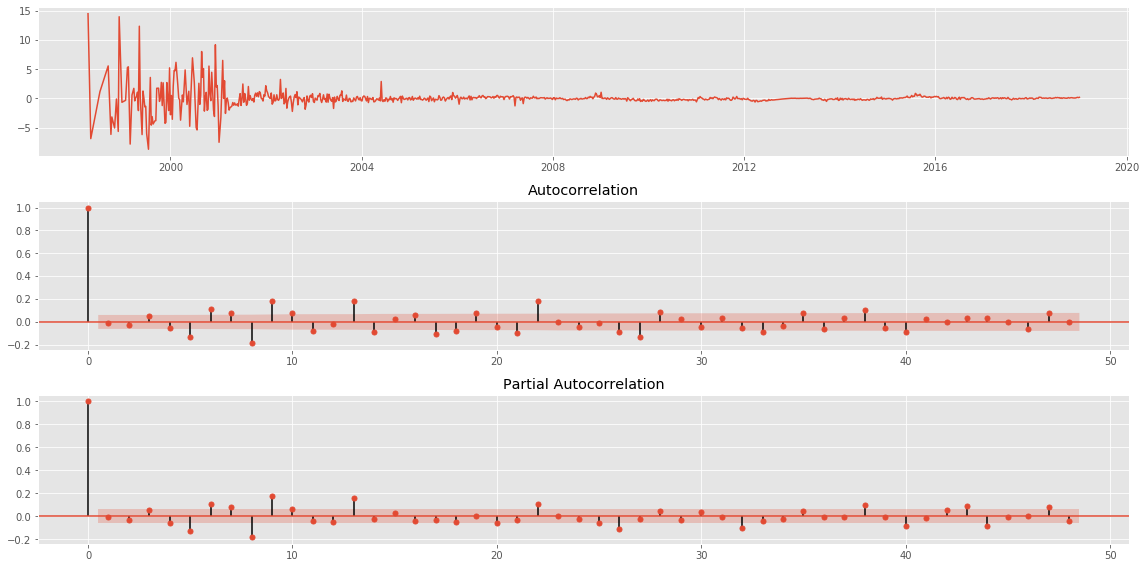

In [37]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

In [31]:
ywn

,cost_per_watt
installation_date,
1998-02-01,6.550
1998-04-12,21.070
1998-05-03,6.620
1998-07-12,12.910
1998-09-13,17.345
...,...
2018-12-09,3.790
2018-12-16,3.850
2018-12-23,3.890


In [38]:
arima_preds = lm_residual_model.predict(ywn.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

In [93]:
# long_df['Week'] = long_df.index.date

In [39]:
arima_preds

installation_date
2019-01-06   -0.136344
dtype: float64

In [33]:
import numpy as np

In [34]:
X = np.column_stack([ywn,
                     add_constant(np.arange(1, len(ywn) + 1))])

lm_preds = pd.Series(
    linear_model.predict(X),
    index=ywn.index)

lm_preds= lm_preds[arima_preds.index.min():]

ValueError: shapes (1036,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

In [65]:
import pandas as pd 
import numpy as np

In [96]:
arima_preds

installation_date
2019-01-06    0.111857
dtype: float64

In [59]:
import pyramid
from pmdarima.arima import auto_arima

In [64]:
wd = np.array(weekly_differences)

sywa = np.array(syw)

In [69]:
auto_arima(wd[1:])

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 4), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [73]:
auto_arima(sywa)

ARIMA(maxiter=50, method='lbfgs', order=(4, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [75]:
mod = ARIMA(weekly_differences, order=(2, 0, 4))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          cost_per_watt   No. Observations:                 1036
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1732.568
Date:                Fri, 13 Mar 2020   AIC                           3481.136
Time:                        02:08:51   BIC                           3520.681
Sample:                             0   HQIC                          3496.140
                               - 1036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.003     -2.419      0.016      -0.013      -0.001
ar.L1         -0.8021      0.002   -357.721      0.000      -0.807      -0.798
ar.L2         -0.9927      0.001   -918.965      0.0

In [76]:
lm_residual_model = ARIMA(
    lm_residuals, order=( 2, 0, 4)).fit()

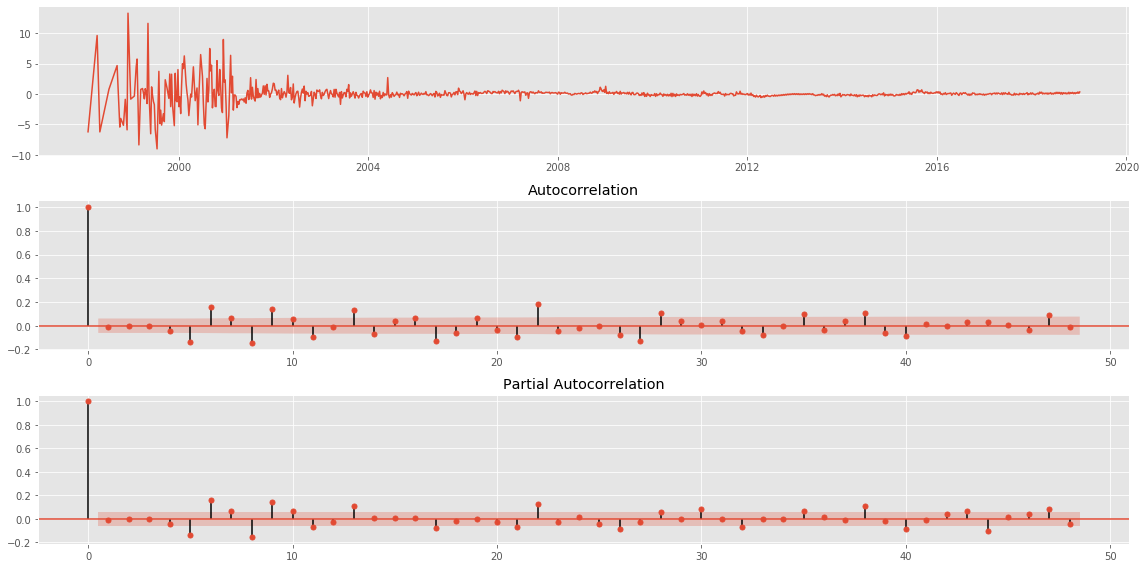

In [77]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

In [78]:
arima_preds = lm_residual_model.predict(ywn.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

In [79]:
arima_preds

installation_date
2019-01-06    0.244509
dtype: float64

In [ ]:
arima_preds = lm_residual_model.predict(weekly_differences.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [465]:
y_hat_avg = weekly_differences.copy()
fit1 = ARIMA(df['cost_per_watt'], order=(2, 0, 4)).fit()
y_hat_avg['ARIMA'] = fit1.predict(start="2019-1-6", end="2020-1-6", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(df['cost_per_watt'], label='Cost Per Watt')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()
model_type = 'ARIMA'
print('RMS Score:',  rms_score(df, model_type))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

get p and q by reviewing AC and PAC - look at at which value the line drops below y-axis 0

In [394]:
X = add_constant(np.arange(1, len(syw) + 1))
y = syw
rf = RandomForestRegressor(oob_score=True,n_jobs=-1)
rf.fit(X,y)

print('OOB Score: {}'.format(rf.oob_score_))
print('r2 score on test: {}'.format(rf.score(X,y)))

rf_predict = rf.predict(X)
mse = mean_squared_error(y,rf_predict)

print('MSE: {}'.format(mse))

OOB Score: 0.9806639020690705
r2 score on test: 0.9974998333500922
MSE: 0.018327212519707172


In [106]:
weekly_differences = syw.diff(periods=1)

In [108]:
w_diff = weekly_differences[1:]

In [109]:
w_diff

,cost_per_watt
installation_date,
2002-01-13,-0.265
2002-01-20,-0.560
2002-01-27,-0.160
2002-02-03,-0.130
2002-02-10,0.935
...,...
2018-12-09,0.010
2018-12-16,0.060
2018-12-23,0.040


In [111]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

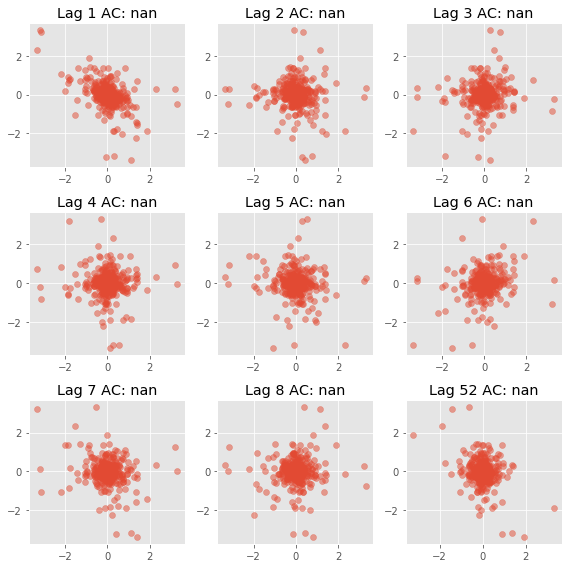

In [112]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [1,2,3,4,5,6,7,8,52]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(w_diff, lag=i)
    autocorr = compute_autocorrelation(w_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

In [113]:
def fit_ar_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(order, 0, 0))
    return model.fit()

In [464]:
for coef in ar_coefs:
    ar_series = auto_regressive_process(size=250, coefs=coef)
    ar_model = fit_ar_model(ar_series.values, order=(len(coef)))
    print("True Coefficients: {0: <26} Estimated Coefficients: {1: <26}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ar_model.params[1:]))))

NameError: name 'ar_coefs' is not defined

In [117]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [130]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coef))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))


In [131]:
mod = ARIMA(weekly_differences, order=(2, 0, 4))
res = ARIMA(weekly_differences, order=(2, 0, 4)).fit()

print("ARIMA(2, 0, 4) coefficients from model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    res.params[0], 
        format_list_of_floats(list(res.params[1:]))))

ARIMA(2, 0, 4) coefficients from model:
  Intercept -0.01
  AR ['-0.94', '-0.84', '0.08', '0.02', '-0.62', '0.01', '0.11']


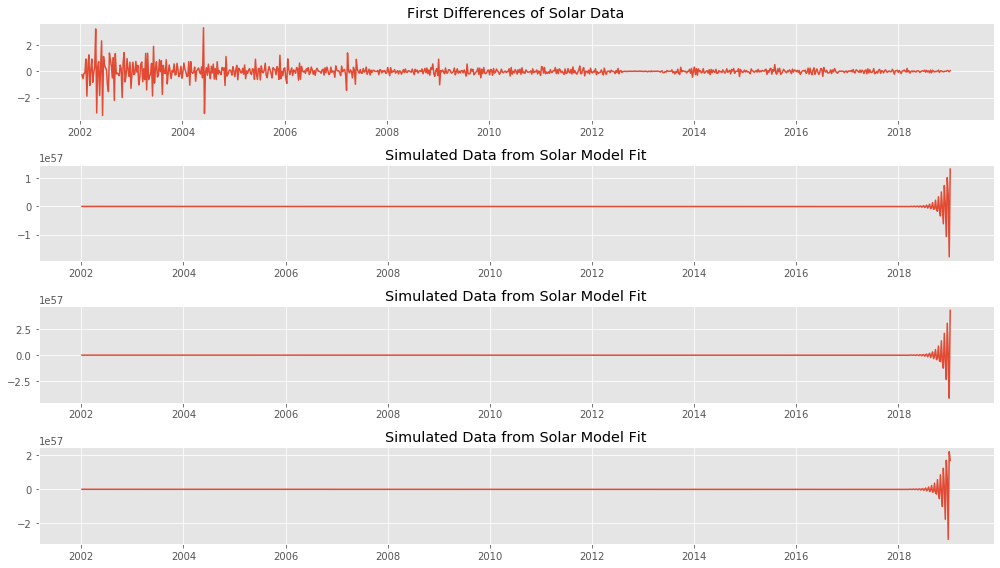

In [132]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(weekly_differences.index, weekly_differences)
ax[0].set_title("First Differences of Solar Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(weekly_differences), list(res.params)[1:])
    simulated_data.index = weekly_differences.index
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Solar Model Fit")
    
plt.tight_layout()


In [133]:
syw

,cost_per_watt
installation_date,
2002-01-06,12.935
2002-01-13,12.670
2002-01-20,12.110
2002-01-27,11.950
2002-02-03,11.820
...,...
2018-12-09,3.790
2018-12-16,3.850
2018-12-23,3.890


In [ ]:
statsmodels.tsa.arima_model.ARIMAResults.plot_predict

In [138]:
res.predict()

installation_date
2002-01-06   -0.009800
2002-01-13   -0.009800
2002-01-20    0.115674
2002-01-27    0.474287
2002-02-03    0.452345
                ...   
2018-12-09   -0.041206
2018-12-16   -0.044999
2018-12-23   -0.102262
2018-12-30   -0.132655
2019-01-06   -0.076719
Freq: W-SUN, Length: 888, dtype: float64

In [ ]:
res = ARIMA(weekly_differences, order=(2, 0, 4)).fit()

In [146]:
from statsmodels.tsa.arima.model import ARIMAResults

In [156]:
#variance/ covariance matrix
ARIMAResults.cov_params(res)

,const,ar.L1,ar.L2,ma.L1,ma.L2,ma.L3,ma.L4,sigma2
const,5.407760e-06,-0.000016,0.000006,0.000014,-0.000024,0.000009,-0.000006,-8.042946e-07
ar.L1,-1.574588e-05,0.003333,0.001608,-0.003030,0.001487,0.001750,-0.000828,1.052974e-05
ar.L2,6.076015e-06,0.001608,0.002119,-0.001462,-0.000884,0.002230,-0.000442,1.000351e-05
ma.L1,1.383379e-05,-0.003030,-0.001462,0.003135,-0.001262,-0.001521,0.000552,-2.289197e-06
ma.L2,-2.376777e-05,0.001487,-0.000884,-0.001262,0.002949,-0.000732,-0.000219,8.350321e-06
ma.L3,8.710298e-06,0.001750,0.002230,-0.001521,-0.000732,0.002633,-0.000320,1.726609e-05
ma.L4,-6.349125e-06,-0.000828,-0.000442,0.000552,-0.000219,-0.000320,0.000668,-1.305210e-06
sigma2,-8.042946e-07,0.000011,0.000010,-0.000002,0.000008,0.000017,-0.000001,2.406860e-06


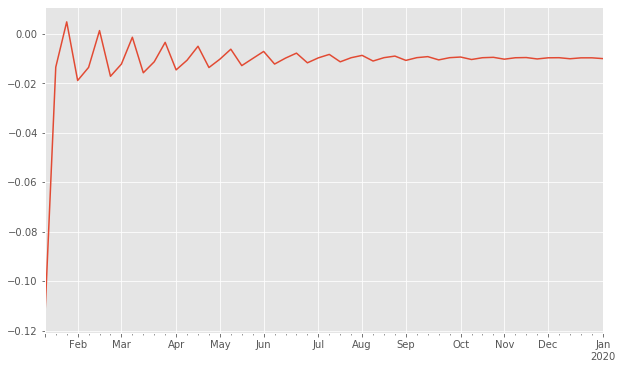

In [161]:
ARIMAResults.forecast(res, steps = 52,).plot()

In [466]:
ARIMAResults.summary()

TypeError: summary() missing 1 required positional argument: 'self'

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot()

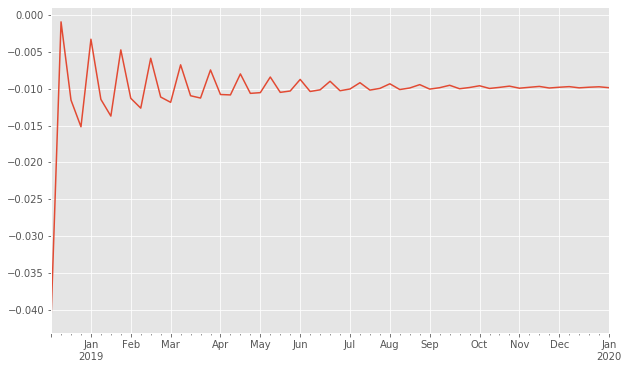

In [170]:
ARIMAResults.predict(res,start = '2018-12-09', end= '2020', dynamic=True).plot()

In [164]:
ARIMAResults.info_criteria(res, 'aic')
ARIMAResults.info_criteria(res, 'bic')

582.0427995076361

In [151]:
ARIMAResults.predict(w_diff.cost_per_watt)

AttributeError: 'Series' object has no attribute 'get_prediction'

In [176]:
res.arparams

array([-0.94280069, -0.83864459])

In [177]:
#standard erorrs
res.bse

const     0.002325
ar.L1     0.057730
ar.L2     0.046032
ma.L1     0.055992
ma.L2     0.054305
ma.L3     0.051313
ma.L4     0.025849
sigma2    0.001551
dtype: float64

In [181]:
res.llf

-263.86551278184936

In [182]:
res.llf_obs

array([ 0.00000000e+00, -2.62716531e-01, -1.52561290e+00, -1.52252621e+00,
       -1.29732913e+00, -1.15896275e+00, -9.48290367e+00, -3.41530360e+00,
       -6.73014531e-01, -1.08285922e+00, -2.71909606e-01, -8.33222606e-01,
        1.38337311e-02, -1.35100414e-01,  1.02864229e-01, -5.20082329e+01,
       -1.70865073e-01,  1.76318924e-01, -9.41077138e-01, -5.50331826e+00,
       -2.64009369e+00, -9.52184576e+00, -1.36126034e+01, -6.65122716e-01,
       -2.39367809e-01, -1.60315667e+00, -9.30629225e-01, -3.95964268e+00,
       -1.80293104e+01, -8.10210997e-01, -3.81517093e-01, -6.07024630e+00,
       -6.58528894e-02, -5.70845380e+00, -4.62605389e+00, -3.93663906e-01,
        1.72920742e-01,  1.82717124e-02, -1.41167488e-01, -1.86717600e+00,
        5.51242034e-02, -1.72974252e-02, -1.54027310e+01, -2.44371759e+00,
       -1.75218779e+00,  1.92569153e-01, -1.47327574e-01, -9.05799732e-01,
       -2.66398210e+00, -3.77149731e-01, -2.32673692e+00, -1.11976180e+00,
       -1.24077879e+00,  

In [185]:
res.maparams

array([ 0.081886  ,  0.02071644, -0.6176283 ,  0.01344409])

In [186]:
res.maroots

array([-0.59900217-0.97622825j, -0.59900217+0.97622825j,
        1.23523311-0.j        , 45.9032605 -0.j        ])

In [187]:
res.pvalues

const     2.506976e-05
ar.L1     5.925585e-60
ar.L2     3.653827e-74
ma.L1     1.436139e-01
ma.L2     7.028448e-01
ma.L3     2.285790e-33
ma.L4     6.029903e-01
sigma2    0.000000e+00
dtype: float64

In [188]:
res.resid

installation_date
2002-01-06         NaN
2002-01-13   -0.255200
2002-01-20   -0.675674
2002-01-27   -0.634287
2002-02-03   -0.582345
                ...   
2018-12-09    0.051206
2018-12-16    0.104999
2018-12-23    0.142262
2018-12-30    0.092655
2019-01-06    0.126719
Freq: W-SUN, Length: 888, dtype: float64

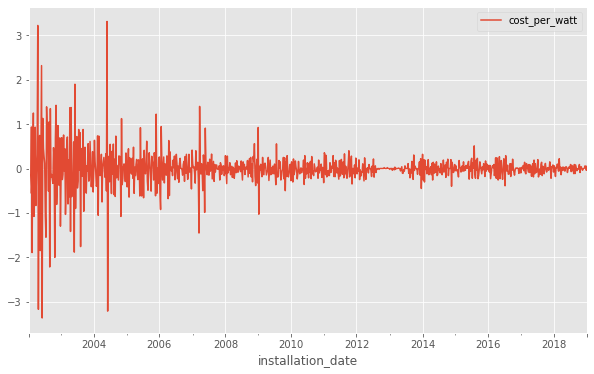

In [208]:
w_diff.plot()

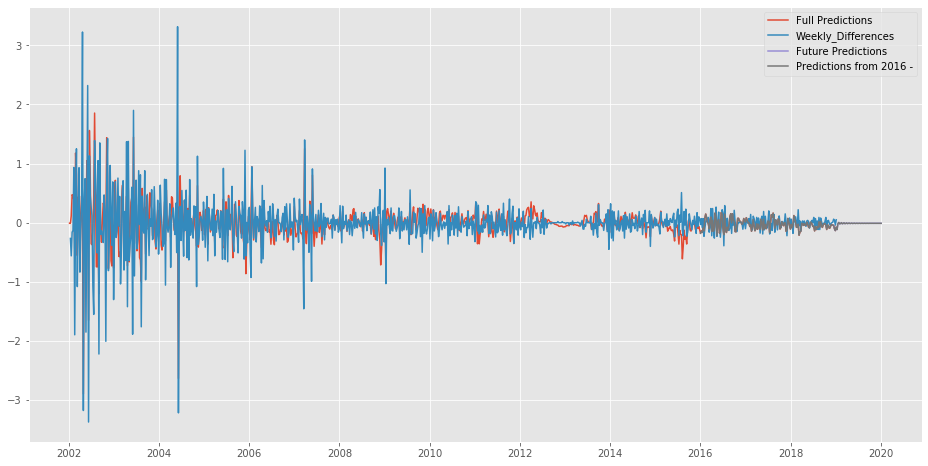

In [228]:
plt.figure(figsize=(16,8))
plt.plot(res.predict(), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 -')
#plt.plot(syw, label = 'Full Data')
plt.legend(loc='best')
plt.show()


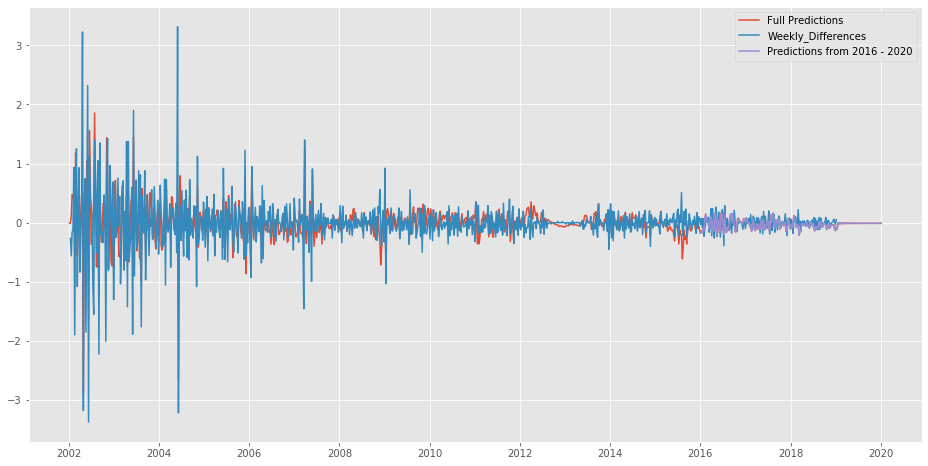

In [240]:
plt.figure(figsize=(16,8))
plt.plot(res.predict(end = '2020'), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
#plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 - 2020')
plt.legend(loc='best')
plt.show()


In [196]:
mod.fit()

In [199]:
mod.fit()

In [231]:
w_diff.loc[w_diff.index.year > 2013]

,cost_per_watt
installation_date,
2014-01-05,0.320
2014-01-12,-0.260
2014-01-19,0.200
2014-01-26,-0.305
2014-02-02,0.185
...,...
2018-12-09,0.010
2018-12-16,0.060
2018-12-23,0.040


In [200]:
pred = res.predict(start = '2018-12-09', end= '2020')

In [201]:
pred

2018-12-09   -0.041206
2018-12-16   -0.044999
2018-12-23   -0.102262
2018-12-30   -0.132655
2019-01-06   -0.076719
2019-01-13   -0.115009
2019-01-20   -0.013447
2019-01-27    0.004853
2019-02-03   -0.018852
2019-02-10   -0.013554
2019-02-17    0.001331
2019-02-24   -0.017145
2019-03-03   -0.012209
2019-03-10   -0.001368
2019-03-17   -0.015729
2019-03-24   -0.011281
2019-03-31   -0.003431
2019-04-07   -0.014562
2019-04-14   -0.010651
2019-04-21   -0.005003
2019-04-28   -0.013608
2019-05-05   -0.010232
2019-05-12   -0.006199
2019-05-19   -0.012833
2019-05-26   -0.009961
2019-06-02   -0.007105
2019-06-09   -0.012206
2019-06-16   -0.009792
2019-06-23   -0.007790
2019-06-30   -0.011702
2019-07-07   -0.009692
2019-07-14   -0.008306
2019-07-21   -0.011298
2019-07-28   -0.009640
2019-08-04   -0.008694
2019-08-11   -0.010977
2019-08-18   -0.009618
2019-08-25   -0.008985
2019-09-01   -0.010721
2019-09-08   -0.009615
2019-09-15   -0.009202
2019-09-22   -0.010519
2019-09-29   -0.009624
2019-10-06 

In [234]:
preds = res.predict(start= '2016-01-03', end= '2020')

In [227]:
preds

2016-01-03   -0.179154
2016-01-10   -0.139635
2016-01-17   -0.163980
2016-01-24   -0.088866
2016-01-31   -0.138885
                ...   
2019-12-08   -0.009636
2019-12-15   -0.010060
2019-12-22   -0.009693
2019-12-29   -0.009683
2020-01-05   -0.010000
Freq: W-SUN, Length: 210, dtype: float64

In [ ]:
plt.plot(res.predict(end = '2020'), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
#plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 - 2020')

In [242]:
all_year_preds = res.predict(end = '2020')
last_four_preds = res.predict(start= '2016-01-03', end= '2020')

In [241]:
w_diff

,cost_per_watt
installation_date,
2002-01-13,-0.265
2002-01-20,-0.560
2002-01-27,-0.160
2002-02-03,-0.130
2002-02-10,0.935
...,...
2018-12-09,0.010
2018-12-16,0.060
2018-12-23,0.040


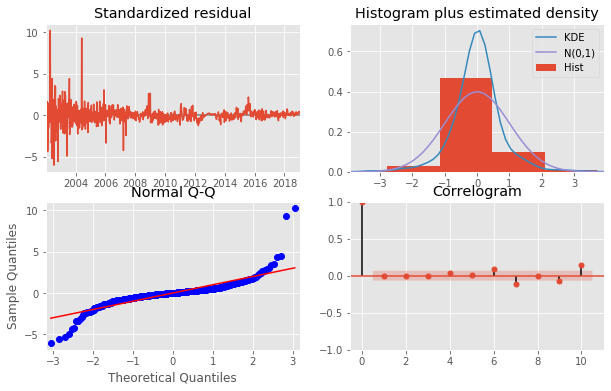

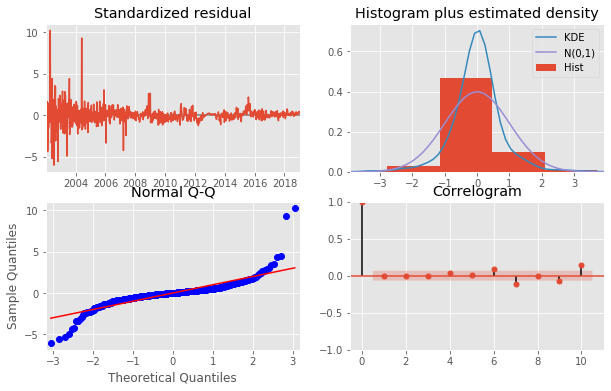

In [257]:
res.plot_diagnostics()

In [382]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
                              #actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
                              #actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'Mean Absolute Percentage Error':mape, 'Mean Error':me, 'Mean Absolute Error ': mae, 
            #'Mean Percentage Error': mpe, 'Root Mean Squared Error ':rmse, #'Lag 1 Autocorrelation of Error':acf1, 
            #'Correlation between the Actual and the Forecast':corr}) #'Min-Max Error ':minmax})
    print('Mean Absolute Percentage Error:  ', mape, '\nMean Error:                      ',me, '\nMean Absolute Error :            ', mae, 
            '\nMean Percentage Error:           ', mpe, '\nRoot Mean Squared Error :        ',rmse, #'Lag 1 Autocorrelation of Error':acf1, 
            '\nCorrelation between the \nActual and the Forecast:         ',corr) #'Min-Max Error ':minmax})

In [383]:
forecast_accuracy(forecastt, actual)

Mean Absolute Percentage Error:   inf 
Mean Error:                       0.000835770942663377 
Mean Absolute Error :             0.18562102619417667 
Mean Percentage Error:            nan 
Root Mean Squared Error :         0.3261506489169117 
Correlation between the 
Actual and the Forecast:          0.6710069749690127


In [294]:
actual = w_diff.cost_per_watt

In [299]:
forecast = pd.DataFrame(all_year_preds[1:])
forecast = forecast[0]
forecastt =  forecast.loc[forecast.index < '2019-01-07']

In [256]:
np.mean(np.abs(w_diff))

cost_per_watt    0.227773
dtype: float64

In [ ]:
res.predict(1,)

In [389]:
X

array([[6.550e+00, 1.000e+00, 1.000e+00],
       [2.107e+01, 1.000e+00, 2.000e+00],
       [6.620e+00, 1.000e+00, 3.000e+00],
       ...,
       [3.890e+00, 1.000e+00, 1.034e+03],
       [3.850e+00, 1.000e+00, 1.035e+03],
       [3.900e+00, 1.000e+00, 1.036e+03]])

OOB Score: 0.9984738799563427
r2 score on test: 0.9998009798193224
MSE: 0.001960314230212374


In [411]:
from sklearn.model_selection import TimeSeriesSplit 

In [416]:
week_differences

,cost_per_watt
installation_date,
2002-01-06,NaN
2002-01-13,-0.265
2002-01-20,-0.560
2002-01-27,-0.160
2002-02-03,-0.130
...,...
2018-12-09,0.010
2018-12-16,0.060
2018-12-23,0.040


In [418]:
s_lagg

,y,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,,
2002-01-27,11.950,12.110,12.670,12.935
2002-02-03,11.820,11.950,12.110,12.670
2002-02-10,12.755,11.820,11.950,12.110
2002-02-17,10.860,12.755,11.820,11.950
2002-02-24,11.150,10.860,12.755,11.820
...,...,...,...,...
2018-12-09,3.790,3.780,3.780,3.790
2018-12-16,3.850,3.790,3.780,3.780


In [422]:
weekly_differences = s_lagg.diff(periods=1)

In [421]:
weekly_differences.dropna(inplace=True)

In [424]:
weekly_differences.dropna().drop(['y'], axis=1)

,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,
2002-02-03,-0.160,-0.560,-0.265
2002-02-10,-0.130,-0.160,-0.560
2002-02-17,0.935,-0.130,-0.160
2002-02-24,-1.895,0.935,-0.130
2002-03-03,0.290,-1.895,0.935
...,...,...,...
2018-12-09,0.000,-0.010,-0.040
2018-12-16,0.010,0.000,-0.010


In [427]:
weekly_differences.y.dropna()

,cost_per_watt
installation_date,
2002-02-03,-0.130
2002-02-10,0.935
2002-02-17,-1.895
2002-02-24,0.290
2002-03-03,1.250
...,...
2018-12-09,0.010
2018-12-16,0.060
2018-12-23,0.040


In [433]:
X_train

,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,
2002-02-03,-0.160,-0.560,-0.265
2002-02-10,-0.130,-0.160,-0.560
2002-02-17,0.935,-0.130,-0.160
2002-02-24,-1.895,0.935,-0.130
2002-03-03,0.290,-1.895,0.935
...,...,...,...
2013-11-03,-0.010,0.010,0.055
2013-11-10,0.000,-0.010,0.010


In [436]:
y.dropna

<bound method DataFrame.dropna of                    cost_per_watt
installation_date               
2002-01-27                   NaN
2002-02-03                -0.130
2002-02-10                 0.935
2002-02-17                -1.895
2002-02-24                 0.290
...                          ...
2018-12-09                 0.010
2018-12-16                 0.060
2018-12-23                 0.040
2018-12-30                -0.040
2019-01-06                 0.050

[885 rows x 1 columns]>

In [439]:
test_index = int(len(X)*(1-.2))

In [443]:
y_train

,cost_per_watt
installation_date,
2002-01-27,NaN
2002-02-03,-0.130
2002-02-10,0.935
2002-02-17,-1.895
2002-02-24,0.290
...,...
2013-10-27,-0.010
2013-11-03,0.000
2013-11-10,-0.130


In [447]:
weekly_differences

,y,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,,
2002-01-27,NaN,NaN,NaN,NaN
2002-02-03,-0.130,-0.160,-0.560,-0.265
2002-02-10,0.935,-0.130,-0.160,-0.560
2002-02-17,-1.895,0.935,-0.130,-0.160
2002-02-24,0.290,-1.895,0.935,-0.130
...,...,...,...,...
2018-12-09,0.010,0.000,-0.010,-0.040
2018-12-16,0.060,0.010,0.000,-0.010


In [448]:
y = weekly_differences.y.dropna()
X = weekly_differences.dropna().drop(['y'], axis=1)

In [449]:
# reserve 20% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [453]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [463]:
coefs

[-0.9428006936714235,
 -0.8386445866839797,
 0.08188599618602632,
 0.020716443369439577,
 -0.6176282998966566,
 0.013444094952072954,
 0.10711202150113519]

Mean absolute percentage error cost_per_watt    624.214927
dtype: float64


ValueError: Shape of passed values is (1, 3), indices imply (3, 3)

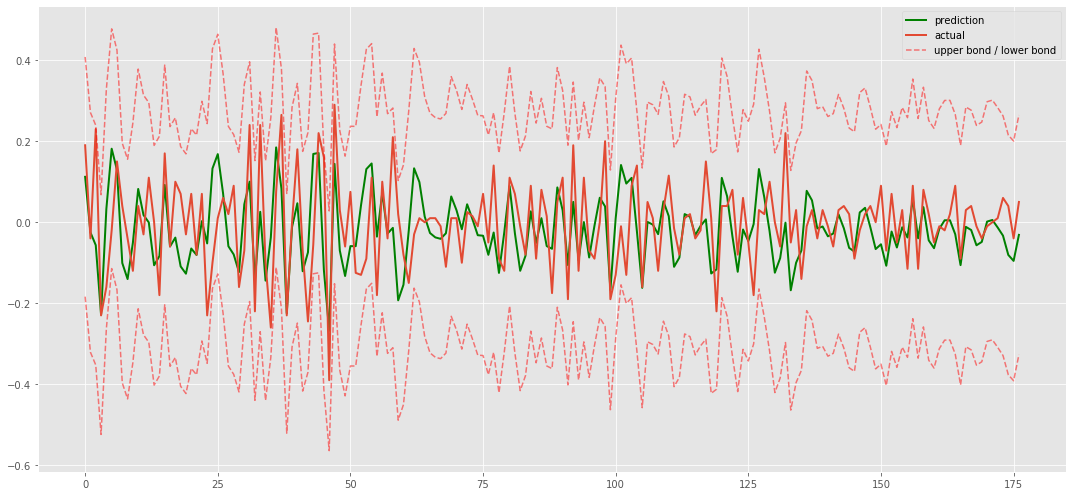

In [461]:
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [444]:
tscv = TimeSeriesSplit(n_splits=3)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
timeseries_train_test_split(X,y, test)

In [458]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    print("Mean absolute percentage error", error)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    

In [460]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    


In [462]:
rf = RandomForestRegressor(oob_score=True,n_jobs=-1)
rf.fit(X,y)

print('OOB Score: {}'.format(rf.oob_score_))
print('r2 score on test: {}'.format(rf.score(X,y)))

rf_predict = rf.predict(X)
mse = mean_squared_error(y,rf_predict)

print('MSE: {}'.format(mse))

OOB Score: 0.25005919080742844
r2 score on test: 0.8957231009162024
MSE: 0.02019615801164712
